# Week 7 Problem 3

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. **If your code does not pass the unit tests, it will not pass the autograder.**

# Due Date: 6 PM, March 5, 2018

In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.metrics import v_measure_score
from nose.tools import assert_equal, assert_in, assert_is_not, assert_is_instance, assert_almost_equal
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal

Let us use _sklearn_ to create a classification dataset for this assignment. We will create a dataset of 500 observations, 4 features and 4 class labels. We will then perform a 80/20 train-test split of the dataset.

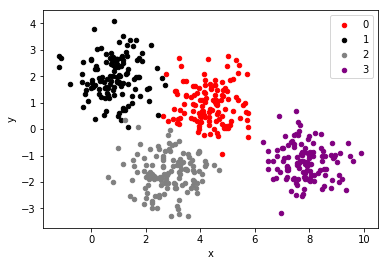

In [2]:
# Generate the dataset
X, y = make_blobs(n_samples=500, centers=4, cluster_std=0.75, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# View the dataset
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0: 'red', 1: 'black', 2: 'gray', 3: 'purple'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

## Question 1

Create a wrapper function called <i>mixture_model()</i> that takes in a _numpy.ndarray_ of data, an _numpy.ndarray_ of labels, and an _int_ specifying the number of components. Your function will fit a <i>sklearn.mixture.gaussian_mixture.GaussianMixture</i> model and return the fitted model along with its prediction.

Set the following parameters for your Gaussian Mixture model (refer to the [Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)):
- Set <i>random_state=0</i>.
- Set the number of initializations to be 10.
- Set the max of EM interations to be 200
- Set the initialization parameter (i.e., <i>init_params</i>) to be 'random'.
- Set the covariance type to be 'full'.

__Note:__ We will default _n_ to be two if it is not specified.

In [8]:
def mixture_model(X, y, n=2):
    '''    
    Parameters
    ----------
    X: A numpy.ndarray representing the data
    y: A numpy.ndarray representing the label
    n: A int specifying the number of components
    
    Returns
    -------
    model: An sklearn.mixture.gaussian_mixture.GaussianMixture instance
    prediction: A numpy.ndarray of predictions
    '''
    
    # YOUR CODE HERE
    model = GaussianMixture(n_components=n, random_state=0, n_init=10,
                            max_iter=200, init_params='random',covariance_type='full')
    model.fit(X)
    prediction = model.predict(X)
    return model, prediction

In [9]:
model, prediction = mixture_model(X,y,4)
assert_equal(len(prediction), 500)
assert_equal(model.n_init, 10)
assert_equal(model.max_iter, 200)
assert_equal(model.n_components, 4)
assert_equal(model.init_params, 'random')


Recall from the lesson that the V-measure score measures the homogeneity and the completeness of the clustering. This metric is built into sklearn (see [Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html)). While we can use this metric to determine the optimal number of components and it is accurate for this case, using accuracy measures should not be used for model selection. Instead, it is better to rely on the information criterion metrics to determine goodness of fit of our mixture model.

In [10]:
# Compute the V-Measure of 2, 3, ..., 10 components
for i in np.arange(2,11):
    model, prediction = mixture_model(X, y, i)
    print('%i components' %i, v_measure_score(y,prediction))

2 components 0.474246235364
3 components 0.790705020428
4 components 0.953606320017
5 components 0.896313623705
6 components 0.904730241663
7 components 0.884395960645
8 components 0.492326498207
9 components 0.62653077936
10 components 0.900874888409


## Question 2

Create the function <i>compute_aic_bic()</i> which takes the data and labels to fit Gaussian Mixture models with _2_ to _k_ components. Your function should return two lists, one with AIC scores and another with BIC scores. Set the parameters of the GMM to be the same as Question 1.

__Example__: <i>compute_aic_bic(X, y, 4)</i> will fit an GMM with k=2,3, and 4. It should return two list of three elements each, corresponding to AIC and BIC scores, respectively.

__Hint__: Use the function you've created in Question 1. You can use the built-in functions to compute the [AIC/BIC score](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.aic).

In [11]:
def compute_aic_bic(X, y, k):
    '''    
    Parameters
    ----------
    X: A numpy.ndarray representing the data
    y: A numpy.ndarray representing the label
    k: A int specifying the max number of components to consider
    
    Returns
    -------
    aic_result: A list of AIC scores
    bic_result: A list of BIC scores
    '''

    # YOUR CODE HERE
    aic_result = []
    bic_result = []
    for i in range(2, k+1):
        model, pred = mixture_model(X,y,i)
        aic_result.append(model.aic(X))
        bic_result.append(model.bic(X))
    return aic_result, bic_result

In [12]:
aic1, bic1 = compute_aic_bic(X, y, 5)

assert_equal(len(aic1), 4)
assert_equal(type(aic1), list)
assert_almost_equal(aic1, [4212.4286306157865, 3792.4137470870855, 3616.391280743926, 3624.524088698493])
assert_equal(len(bic1), 4)
assert_equal(type(bic1), list)
assert_almost_equal(bic1, [4258.7893196984305, 3864.0620847602627, 3713.3272670076362, 3746.7477235527367])


Let us plot your results for 2, 3, 4, and 5 components. You should see that 4 components is optimal (which corresponds to the highest V-measure as well).

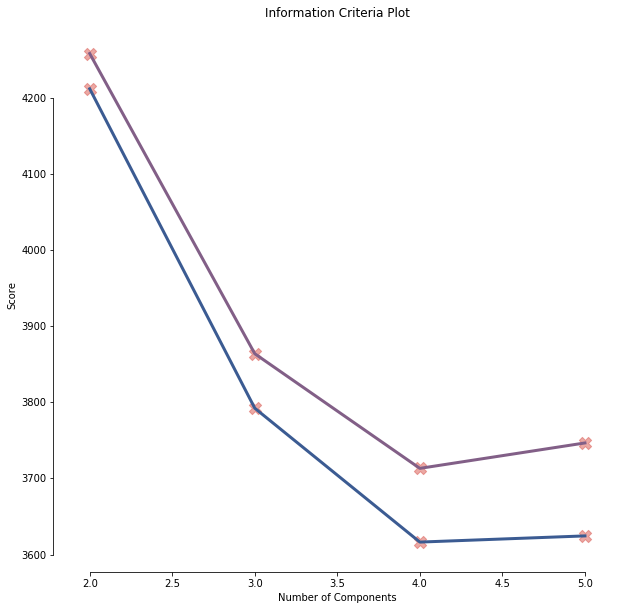

In [13]:
# Plot the AIC/BIC Curves
fig, ax = plt.subplots(figsize=(10, 10))

# Show AIC points an curve
ax.scatter(np.arange(2, 6), aic1, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(np.arange(2, 6), aic1, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['denim blue'], label='AIC')

# Show BIC points an curve
ax.scatter(np.arange(2, 6), bic1, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(np.arange(2, 6), bic1, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['dusty purple'], label='BIC')

# Decorate Plot
ax.set(title='Information Criteria Plot',
       xlabel='Number of Components', 
       ylabel='Score')
sns.despine(offset=5, trim=True)

## Question 3

We can also use AIC/BIC to determine the hyperparameter for covariance type.

Create a wrapper function called <i>aic_bic_covariance_type()</i> that takes in a _numpy.ndarray_ of data and a _numpy.ndarray_ of labels. Your function will fit a <i>sklearn.mixture.gaussian_mixture.GaussianMixture</i> model with the following parameters for your Gaussian Mixture model:
- Set <i>random_state=0</i>.
- Set the number of components to be 4.
- Set the number of initializations to be 10.
- Set the max of EM interations to be 200
- Set the initialization parameter (i.e., <i>init_params</i>) to be 'random'.

Instead of iterating over the number of components, iterate over the four different covariance types (in specific order: 'full', 'tied', 'diag', 'spherical'). Your function should return two lists, one for the AIC scores and one for the BIC scores corresponding to each types.

In [20]:
def aic_bic_covariance_type(X, y):
    '''    
    Parameters
    ----------
    X: A numpy.ndarray representing the data
    y: A numpy.ndarray representing the label
    
    Returns
    -------
    aic_result: A list of AIC scores
    bic_result: A list of BIC scores
    '''

    # YOUR CODE HERE
    cov = ['full', 'tied', 'diag', 'spherical']
    aic_result = []
    bic_result = []
    for i in cov:
        model = GaussianMixture(n_components=4, random_state=0, n_init=10,
                            max_iter=200, init_params='random',covariance_type=i)
        model.fit(X)
        aic_result.append(model.aic(X))
        bic_result.append(model.bic(X))
    return aic_result, bic_result

[3616.391280743926, 4219.6443843266297, 4365.7307075900226, 3605.6425008679053]

In [21]:
aic3, bic3 = aic_bic_covariance_type(X, y)

assert_equal(len(aic3), 4)
assert_equal(type(aic3), list)
assert_almost_equal(aic3, [3616.391280743926, 4219.6443843266297, 4365.7307075900226, 3605.6425008679053])
assert_equal(len(bic3), 4)
assert_equal(type(bic3), list)
assert_almost_equal(bic3, [3713.3272670076362, 4278.6488977045401, 4445.8082614600444, 3668.8616223442382])
